# A basic example of how to fit a light curve
To generate a lightcurve for a set of binary parameters, ellc is used 

To install:
- pip install ellc --user

Other python packages needed to run this whole notebook:
- scipy: pip install scipy
- emcee: pip install emcee
- corner: pip install corner

Note that other code is available to model eclipsing binary stars; for example:
- phoebe and phoebe2, http://phoebe-project.org/
- JKTEBOP, http://www.astro.keele.ac.uk/jkt/codes/jktebop.html
- Lcurve, https://github.com/trmrsh?tab=repositories




In [144]:
import numpy as np
import ellc
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

In [145]:
# two spherical stars
def basic_model(t,pars,grid='default'):
    """ a function which returns model values at times t for parameters pars
    
    input:
        t    a 1D array with times
        pars a 1D array with parameter values; r1,r2,J,i,t0,p
        
    output:
        m    a 1D array with model values at times t
    
    """
    try:
        m = ellc.lc(t_obs=t,
                radius_1=pars[0],
                radius_2=pars[1],
                sbratio=pars[2],
                incl=pars[3],
                t_zero=pars[4],
                period=pars[5],
                shape_1='sphere',
                shape_2='sphere',
                grid_1=grid,
                grid_2=grid)
        m *= pars[6]

    except:
        print "Failed with parameters:", pars
        return t * 10**99

    return m

In [146]:
# Parameters used to generate a test lightcurve
r1 = 0.11234
r2 = 0.051243
J = 0.22321
i = 86.7438
t0 = 0.0432
p = 0.18563
scale = 1.231

In [147]:
# generate the test light curve given parameters
model_pars = [r1,r2,J,i,t0,p,scale] # the parameters
t = np.arange(0,6./24.,1./60./24) # a lightcurve with a 1 minute sampling for 6 hours
dy = 0.01+0.01*np.random.rand(np.size(t))  # uncertainty on the points
dy *= scale

# and add errors
y = basic_model(t,model_pars)
y += dy*np.random.randn(np.size(t))
lc = np.c_[t,y,dy*np.ones_like(y)]

# save the test lc to disk
np.savetxt('test.lc',lc)

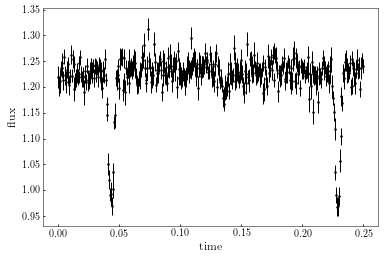

In [148]:
# lets have a look:
plt.errorbar(lc[:,0],lc[:,1],lc[:,2],fmt='k.')
plt.ylabel('flux')
plt.xlabel('time')
plt.show()


# HOW TO FIND THE SYSTEM PARAMETERS FOR THIS LC?

Given a lightcure, what are the underlying parameters? 
This process can be divided in three steps:
- find the global solution
- find the optimal solution
- find the uncertainty on the best solution


## The global solution
This step requires some intuition about eclipsing lightcurve binary stars (a neural net might be usefull here). Read up on the geometry of binary stars before trying to tackle lightcurves in real life.

The most important parameter you want to determine first is the period (*P*). This can be done by using some kind of period finding algorithm in the case of long baseline data or in this case simply by eyeballing the data. 

The second parameter is t0; which is usually lowest point in the LC.

After this it gets more tricky: you need to adjust the values for *r1*,*r2* and *J* (keep *i* at 90 and set the scale to the median of the lc).

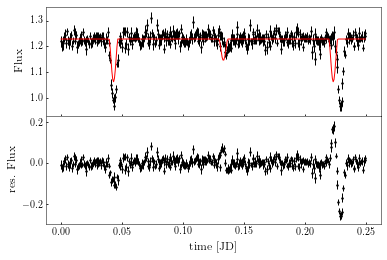

In [149]:
# my initial guess (r1,r2,J,i,t0,p,scale)
guess = np.array([0.1,0.05,0.5,85.,0.043,0.18,np.median(y)])
plot(guess,lc,basic_model)

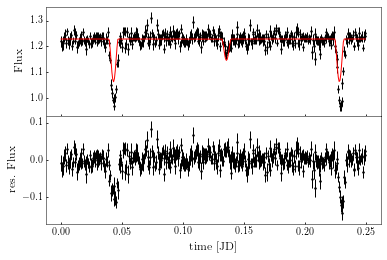

In [150]:
# update the guess: the period estimate seems to be slightly wrong
# my initial guess (r1,r2,J,i,t0,p,scale)
guess = np.array([0.1,0.05,0.5,85.,0.043,0.185,np.median(y)])
plot(guess,lc,basic_model)

## The optimal solution
While the lightcurve model is cleary not correct, but it is close enough to be able to use a minimizer. When you have reached this point is difficult to say, but atleast make sure the period and t0 are correct. The depth of the eclipses is less important.

To be able to use a minimizer we need to define a 'goodness-of-fit' score; the lnp function.
For background, read "Data analysis recipes: Fitting a model to data" https://arxiv.org/abs/1008.4686 or 
"Data Analysis: A Bayesian Tutorial" by Sivia

In [151]:
# we need to compare the data with the model. This function calculates the lnp value
def lnp(pars,data,model,grid='very_sparse',verbose=1):
    """A function which takes as input the parameters, the lightcurve data, and 
    the modelfunction and return the lnp value"""
    
    # first, check the parameters
    if pars[3] > 90: # i cannot be more than 90
        return -np.inf

    m = model(data[:,0],pars,grid) # calculate the model values
    chi2 = np.sum( ((data[:,1]-m)/data[:,2])**2 ) # calculate the chi-square value
    lnp = -0.5*chi2 # lnp=-0.5*chi2 

    if verbose:
        print('%d/%.1f' %(np.size(t),chi2))
    return lnp


In [152]:
# now we have a way to compare data with a model, lets find the best model
from scipy.optimize import minimize

# optimizers work better if you give them the typical scalefactor of each parameter
guess_scale = np.array([-2.,-2.,-2.,0.,-2.,-2.,-2.],dtype=float)


In [153]:
# because scipy has minimizers, we convert lnp to chi2
chi2 = lambda *args: -2*lnp(*args)

# find the optimal solution using nelder-mead
out = minimize(
            fun=chi2, # function to minimize
            x0=guess, # initial value
            args=(lc,basic_model,'very_sparse',False), # the arguments for 'fun'
            method='nelder-mead', # method
            options={'maxiter': 1000, # method options
                     'fatol': 0.1, # if improvement is <fatol, stop
                     'initial_simplex':make_initial_simplex(guess,guess_scale)})
print("N/Chi2: %d/%.1f" %(np.size(lc[:,0]),out.fun))

N/Chi2: 360/389.5


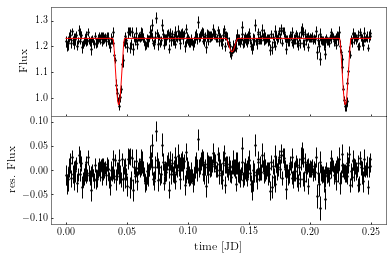

In [154]:
# lets check what the minimizer found as best solution
plot(out.x,lc,basic_model)

## The uncertainties
with a good enough solution (no significant trends in the residual) 
we can try to get the uncertainties on the parameter estimates. The go-to method is emcee, a parallel Markov Chain Monte Carlo sampler. I strongly recommend to have a look at the tutorial here: http://dfm.io/emcee/current/

In [155]:
import emcee

# emcee setup
ndim, nwalkers = np.size(guess), 256
sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                lnp, 
                                args=(lc,basic_model,'very_sparse',False),
                                threads=7)

# set start position for all walkers
pos = [out.x + 10**(guess_scale-2)*np.random.randn(ndim) for i in range(nwalkers)]



Failed with parameters: [ 1.31699000e-01 -1.00501199e-02  1.10939321e-01  8.98555520e+01
  4.33720220e-02  1.85409608e-01  1.22818985e+00]
Failed with parameters: [ 1.33273955e-01 -1.95430466e-03  2.70468099e-01  8.95122835e+01
  4.31570413e-02  1.85502545e-01  1.23406257e+00]
Failed with parameters: [ 1.50956909e-01 -9.34313613e-03  3.15612502e-01  8.94918799e+01
  4.31765839e-02  1.85682372e-01  1.22874621e+00]
Failed with parameters: [ 1.38167899e-01 -7.37372844e-05  1.42912305e-01  8.90436213e+01
  4.31883584e-02  1.85626530e-01  1.22848175e+00]
Failed with parameters: [ 1.30206422e-01 -8.83759420e-04  2.16631059e-01  8.98158285e+01
  4.31190420e-02  1.85650418e-01  1.23050690e+00]
Failed with parameters: [ 1.37869772e-01 -7.64702539e-04  1.68612217e-01  8.94582189e+01
  4.33487950e-02  1.85444184e-01  1.23154450e+00]
Failed with parameters: [ 1.45438518e-01 -1.09134377e-02  2.07945146e-01  8.94414334e+01
  4.32457506e-02  1.85374421e-01  1.23190094e+00]
Failed with parameters: [ 1

  4.32503105e-02  1.85407723e-01  1.23059587e+00]
Failed with parameters: [ 1.36801168e-01 -1.42500816e-02  1.64530733e-01  8.99080840e+01
  4.30996176e-02  1.85390006e-01  1.23273520e+00]
Failed with parameters: [ 1.38921034e-01 -1.07424117e-02  2.68100457e-01  8.98304775e+01
  4.33195178e-02  1.85192981e-01  1.23118260e+00]
Failed with parameters: [ 1.42871481e-01 -1.90669253e-03  2.08065648e-01  8.94929870e+01
  4.33196054e-02  1.85359281e-01  1.22771458e+00]
Failed with parameters: [ 1.47783719e-01 -1.21687005e-02  1.68476361e-01  8.94469019e+01
  4.33545554e-02  1.85283985e-01  1.23099275e+00]
Failed with parameters: [ 1.50516811e-01 -3.39631170e-03  1.81926871e-01  8.82621432e+01
  4.30227343e-02  1.85674928e-01  1.22815585e+00]
Failed with parameters: [ 1.38855278e-01 -5.31504453e-03  2.77167306e-01  8.96241767e+01
  4.31365438e-02  1.85818947e-01  1.22596108e+00]
Failed with parameters: [ 1.57248003e-01 -2.36408676e-02  3.01292814e-01  8.95084298e+01
  4.31091795e-02  1.8571546

  4.31240207e-02  1.85653940e-01  1.23001823e+00]
Failed with parameters: [ 1.40765125e-01 -1.22307559e-03  2.02094721e-01  8.86271732e+01
  4.30962539e-02  1.85534843e-01  1.23443123e+00]
Failed with parameters: [ 1.60178704e-01 -9.63141710e-03  1.55454858e-01  8.77294710e+01
  4.32858497e-02  1.85408560e-01  1.23466446e+00]
Failed with parameters: [ 1.29073779e-01 -7.82076429e-03  3.06801011e-01  8.97375250e+01
  4.32662899e-02  1.85382439e-01  1.22955544e+00]
Failed with parameters: [ 1.46239402e-01 -1.94575100e-02  2.47589375e-01  8.98244238e+01
  4.33228014e-02  1.85348381e-01  1.23026771e+00]
Failed with parameters: [ 1.55012381e-01 -1.83569984e-02  1.85932684e-01  8.89258302e+01
  4.29744371e-02  1.85681881e-01  1.23191181e+00]
Failed with parameters: [ 1.33033590e-01 -2.42503092e-03  1.53232656e-01  8.96108696e+01
  4.31393704e-02  1.85540470e-01  1.23401321e+00]
Failed with parameters: [ 1.55508539e-01 -1.90248670e-03  1.65353467e-01  8.81160442e+01
  4.31948136e-02  1.8532401

  4.31516179e-02  1.85732867e-01  1.23410070e+00]
Failed with parameters: [ 1.38134226e-01 -3.05022371e-04  2.76149921e-01  8.92073555e+01
  4.31659848e-02  1.85574382e-01  1.23342694e+00]
Failed with parameters: [ 1.51486761e-01 -2.20188448e-03  1.87500975e-01  8.89738150e+01
  4.30486686e-02  1.85636158e-01  1.23502545e+00]
Failed with parameters: [-3.12673842e-03  2.51217703e-01  2.11790329e-01  7.77666335e+01
  4.29580656e-02  1.85603766e-01  1.22850038e+00]
Failed with parameters: [ 1.60504693e-01 -3.16982759e-02  1.65131673e-01  8.94765381e+01
  4.31732487e-02  1.85639946e-01  1.23274852e+00]
Failed with parameters: [ 1.43940629e-01 -7.86778420e-03  2.71631876e-01  8.94874167e+01
  4.30284161e-02  1.86055530e-01  1.23149229e+00]
Failed with parameters: [ 1.63723016e-01 -2.05186304e-02  2.87381212e-01  8.93372010e+01
  4.34877368e-02  1.85191520e-01  1.23133663e+00]
Failed with parameters: [ 1.56322336e-01 -3.46447618e-03  2.76098055e-01  8.82389196e+01
  4.30146989e-02  1.8570675

  4.29928948e-02  1.85883898e-01  1.23199379e+00]
Failed with parameters: [ 1.68966983e-01 -2.03516473e-02  2.42687497e-01  8.84099676e+01
  4.33367591e-02  1.85961217e-01  1.22773384e+00]
Failed with parameters: [ 1.45658045e-01 -1.22550183e-02  3.34681671e-01  8.93018032e+01
  4.31026330e-02  1.85654109e-01  1.23044444e+00]
Failed with parameters: [ 1.52056383e-01 -2.42386473e-02  1.86675576e-01  8.94289078e+01
  4.32101948e-02  1.85250382e-01  1.23270890e+00]
Failed with parameters: [ 1.42494853e-01 -1.36128362e-02  2.78023782e-01  8.96255169e+01
  4.33248839e-02  1.85735732e-01  1.22987395e+00]
Failed with parameters: [ 1.53244276e-01 -8.27072743e-03  1.50203694e-01  8.84311622e+01
  4.28673404e-02  1.85916958e-01  1.23171657e+00]
Failed with parameters: [ 1.40664721e-01 -1.22026682e-02  1.95539669e-01  8.93244813e+01
  4.32318463e-02  1.85668462e-01  1.23051133e+00]
Failed with parameters: [ 1.46340621e-01 -3.59334652e-03  1.74307830e-01  8.91904655e+01
  4.31736273e-02  1.8570627

  4.32372010e-02  1.85640508e-01  1.23109346e+00]
Failed with parameters: [ 1.39732846e-01 -5.22046538e-03  2.89630981e-01  8.91848671e+01
  4.33095116e-02  1.85506730e-01  1.23447869e+00]
Failed with parameters: [ 1.39753699e-01 -1.99863027e-04  1.29651255e-01  8.84142812e+01
  4.28923768e-02  1.85911017e-01  1.23152856e+00]
Failed with parameters: [ 1.47905915e-01 -4.16192422e-03  1.98470303e-01  8.90549189e+01
  4.31387459e-02  1.85713027e-01  1.23463779e+00]
Failed with parameters: [ 1.61482021e-01 -2.43983827e-03  1.65916005e-01  8.75713575e+01
  4.29911771e-02  1.85789740e-01  1.23221726e+00]
Failed with parameters: [ 1.46255113e-01 -6.64117821e-04  7.53292634e-02  8.86176238e+01
  4.32457711e-02  1.85330048e-01  1.23094181e+00]
Failed with parameters: [ 1.52740712e-01 -4.67271037e-04  1.46347860e-01  8.73222997e+01
  4.31694771e-02  1.85732536e-01  1.23121600e+00]
Failed with parameters: [ 1.37757502e-01 -4.28085718e-03  2.02523541e-01  8.87578462e+01
  4.32111188e-02  1.8589459

  4.30725224e-02  1.85844772e-01  1.22674162e+00]
Failed with parameters: [ 1.38993322e-01 -2.34621488e-03  1.30322115e-01  8.91554904e+01
  4.32474806e-02  1.85645167e-01  1.23103864e+00]
Failed with parameters: [ 1.40955369e-01 -6.25773906e-03  1.65030568e-01  8.95298621e+01
  4.32268575e-02  1.85567423e-01  1.22884371e+00]
Failed with parameters: [ 1.38140471e-01 -7.25775659e-03  2.17497457e-01  8.89713544e+01
  4.31449629e-02  1.85799709e-01  1.23214076e+00]
Failed with parameters: [ 1.51261738e-01 -1.09194345e-03  2.98039932e-01  8.84643093e+01
  4.32303751e-02  1.85449417e-01  1.23171542e+00]
Failed with parameters: [ 1.41026261e-01 -1.99732788e-03  2.22014848e-01  8.92212831e+01
  4.30776750e-02  1.85792871e-01  1.23027640e+00]
Failed with parameters: [ 1.55537157e-01 -1.37051618e-02  2.04016091e-01  8.90449882e+01
  4.29759436e-02  1.86031571e-01  1.23020225e+00]
Failed with parameters: [ 1.51364024e-01 -6.90726528e-03  2.03585911e-01  8.87451502e+01
  4.31214086e-02  1.8549350

  4.32286374e-02  1.85552436e-01  1.23106193e+00]
Failed with parameters: [ 1.57396085e-01 -1.38463136e-03  2.38830742e-01  8.83334294e+01
  4.32589757e-02  1.85610404e-01  1.22836089e+00]
Failed with parameters: [ 1.57570504e-01 -3.55600111e-03  1.75874830e-01  8.91212818e+01
  4.32093601e-02  1.85489028e-01  1.23325266e+00]
Failed with parameters: [ 1.54900193e-01 -1.66029807e-02  2.41732419e-01  8.98573590e+01
  4.34394580e-02  1.85751513e-01  1.23276661e+00]
Failed with parameters: [ 1.59055902e-01 -8.45185371e-03  2.07419504e-01  8.94110870e+01
  4.32876982e-02  1.85518130e-01  1.23246167e+00]
Failed with parameters: [ 1.65312350e-01 -2.63950514e-02  2.38503853e-01  8.97230317e+01
  4.31950265e-02  1.85726168e-01  1.22938339e+00]
Failed with parameters: [ 1.38065642e-01 -2.86305122e-03  2.85501116e-01  8.88544382e+01
  4.30699414e-02  1.85635838e-01  1.23208308e+00]
Failed with parameters: [ 1.59557163e-01 -1.68918384e-02  2.48953154e-01  8.93306059e+01
  4.31671711e-02  1.8576272

  4.32016486e-02  1.85424605e-01  1.23223620e+00]
Failed with parameters: [ 1.38866016e-01 -5.65845654e-03  1.64205301e-01  8.95310496e+01
  4.30451095e-02  1.85865324e-01  1.23103278e+00]
Failed with parameters: [ 1.31099026e-01 -1.50135932e-04  2.20741135e-01  8.97156971e+01
  4.29258111e-02  1.85942619e-01  1.23172180e+00]
Failed with parameters: [ 1.61017524e-01 -5.46261179e-03  1.37305956e-01  8.76334852e+01
  4.30663448e-02  1.85706604e-01  1.22987835e+00]
Failed with parameters: [ 1.59903499e-01 -4.38728590e-04  2.59502556e-01  8.68549075e+01
  4.32256147e-02  1.85725628e-01  1.23272709e+00]
Failed with parameters: [ 1.35728757e-01 -1.39657898e-02  2.50450640e-01  8.94042178e+01
  4.29412206e-02  1.85954947e-01  1.23243222e+00]
Failed with parameters: [ 1.43658323e-01 -2.59697281e-03  1.77639320e-01  8.88007512e+01
  4.32400132e-02  1.85518510e-01  1.23317470e+00]
Failed with parameters: [ 1.49635284e-01 -8.99726828e-04  1.54715551e-01  8.79485910e+01
  4.30871290e-02  1.8557806

  4.30530320e-02  1.85768738e-01  1.22961035e+00]
Failed with parameters: [ 1.41850643e-01 -1.63162355e-02  2.59056289e-01  8.97847472e+01
  4.33830054e-02  1.85299363e-01  1.22724751e+00]
Failed with parameters: [ 1.62211924e-01 -1.54918021e-02  6.89425324e-02  8.85384148e+01
  4.33992325e-02  1.85339705e-01  1.22826568e+00]
Failed with parameters: [ 1.52048824e-01 -1.00718667e-02  1.91815116e-01  8.86695528e+01
  4.31341454e-02  1.85630200e-01  1.23100394e+00]
Failed with parameters: [ 1.55973819e-01 -3.21528621e-03  1.69915966e-01  8.80467363e+01
  4.33221583e-02  1.85151674e-01  1.23434960e+00]
Failed with parameters: [ 1.31587200e-01 -1.01091713e-03  1.29431799e-01  8.95311619e+01
  4.29352591e-02  1.85834194e-01  1.22995360e+00]
Failed with parameters: [ 1.34244853e-01 -9.59314151e-03  1.98000993e-01  8.87726258e+01
  4.30251349e-02  1.85713672e-01  1.23152337e+00]
Failed with parameters: [ 1.45638476e-01 -3.69642874e-03  2.80711477e-01  8.81669903e+01
  4.33297833e-02  1.8523801

  4.31557503e-02  1.85366120e-01  1.22577805e+00]
Failed with parameters: [ 1.64028192e-01 -6.34544269e-03  2.39159118e-01  8.78923530e+01
  4.31338362e-02  1.85384204e-01  1.23138547e+00]
Failed with parameters: [ 1.47035912e-01 -5.25694335e-03  2.46027491e-01  8.92498814e+01
  4.35496850e-02  1.85148930e-01  1.23186341e+00]Failed with parameters: [ 1.26511830e-01 -8.29376260e-04  1.68548907e-01  8.97731398e+01
  4.30304845e-02  1.85476029e-01  1.22993430e+00]

Failed with parameters: [ 1.49034310e-01 -1.94096527e-02  1.57477307e-01  8.97132951e+01
  4.31010834e-02  1.85676521e-01  1.22894182e+00]
Failed with parameters: [ 1.59891026e-01 -7.90190369e-03  1.62083321e-01  8.86385736e+01
  4.31668372e-02  1.85898055e-01  1.23125755e+00]
Failed with parameters: [ 1.54508095e-01 -2.39176545e-03  7.16042774e-02  8.81194620e+01
  4.31104174e-02  1.85743699e-01  1.23075091e+00]
Failed with parameters: [ 1.43285135e-01 -3.58915829e-03  1.57544752e-01  8.87919443e+01
  4.30559482e-02  1.8594329

  4.30101300e-02  1.85481713e-01  1.23277090e+00]
Failed with parameters: [ 1.29561969e-01 -5.48511081e-05  2.73359382e-01  8.94429066e+01
  4.32850638e-02  1.85509591e-01  1.22812627e+00]
Failed with parameters: [ 1.58287615e-01 -2.90942391e-02  2.61908678e-01  8.97404155e+01
  4.30377977e-02  1.85800534e-01  1.22609112e+00]
Failed with parameters: [ 1.41165482e-01 -2.09368426e-03  1.92514958e-01  8.88249934e+01
  4.31307099e-02  1.85696061e-01  1.22897820e+00]
Failed with parameters: [-6.43917771e-03  2.19109448e-01  2.30335603e-01  8.02029745e+01
  4.30458771e-02  1.85569518e-01  1.23259573e+00]Failed with parameters: [ 1.39745990e-01 -1.80405014e-03  2.77927960e-01  8.93739630e+01
  4.32114439e-02  1.85606614e-01  1.23227395e+00]

Failed with parameters: [ 1.44815826e-01 -6.95431485e-03  2.20103469e-01  8.92957023e+01
  4.33147355e-02  1.85560035e-01  1.23147719e+00]
Failed with parameters: [ 1.42603752e-01 -4.71421480e-03  2.11886170e-01  8.96153596e+01
  4.32211145e-02  1.8559757

In [156]:
# start fitting! Note that this might take a few minutes
niter = 200 # a burning of 200 iterations
sampler.run_mcmc(pos, niter)

# from this initial run, take the best solutions and start a new run, now much longer
best = sampler.flatchain[np.argsort(sampler.flatlnprobability)[-nwalkers:]]
niter = 2000 # a production of 800
sampler.run_mcmc(best, niter)



(array([[0.10680841, 0.07591887, 0.1918783 , ..., 0.04323949, 0.18571643,
         1.23115964],
        [0.11282878, 0.06004369, 0.19081741, ..., 0.04316301, 0.18571275,
         1.23038525],
        [0.07187308, 0.15234191, 0.18886117, ..., 0.04310232, 0.18553205,
         1.23159146],
        ...,
        [0.10993786, 0.07402738, 0.19328848, ..., 0.04309505, 0.18571834,
         1.22925907],
        [0.11585383, 0.06053821, 0.22999567, ..., 0.04315906, 0.18560522,
         1.23263929],
        [0.11110763, 0.06177649, 0.14817808, ..., 0.04323642, 0.1856222 ,
         1.23023871]]),
 array([-199.90837062, -196.241647  , -202.03828155, -197.41834819,
        -195.82982264, -199.01212819, -201.04107367, -196.57136981,
        -196.88370807, -201.87150425, -197.74926562, -197.80277584,
        -199.21562879, -199.57181281, -199.20213036, -201.0189647 ,
        -196.75227223, -196.44034483, -197.63601547, -195.25908802,
        -199.43164027, -196.74223463, -201.58985882, -198.45500067,
 

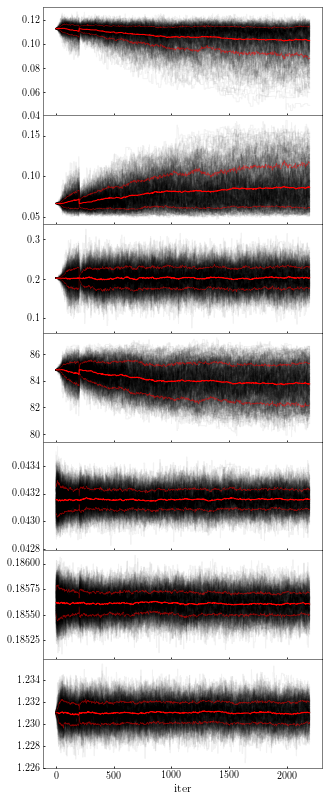

In [157]:
# lets see how the walkers are doing
plot_chain(sampler.flatchain,nwalkers)


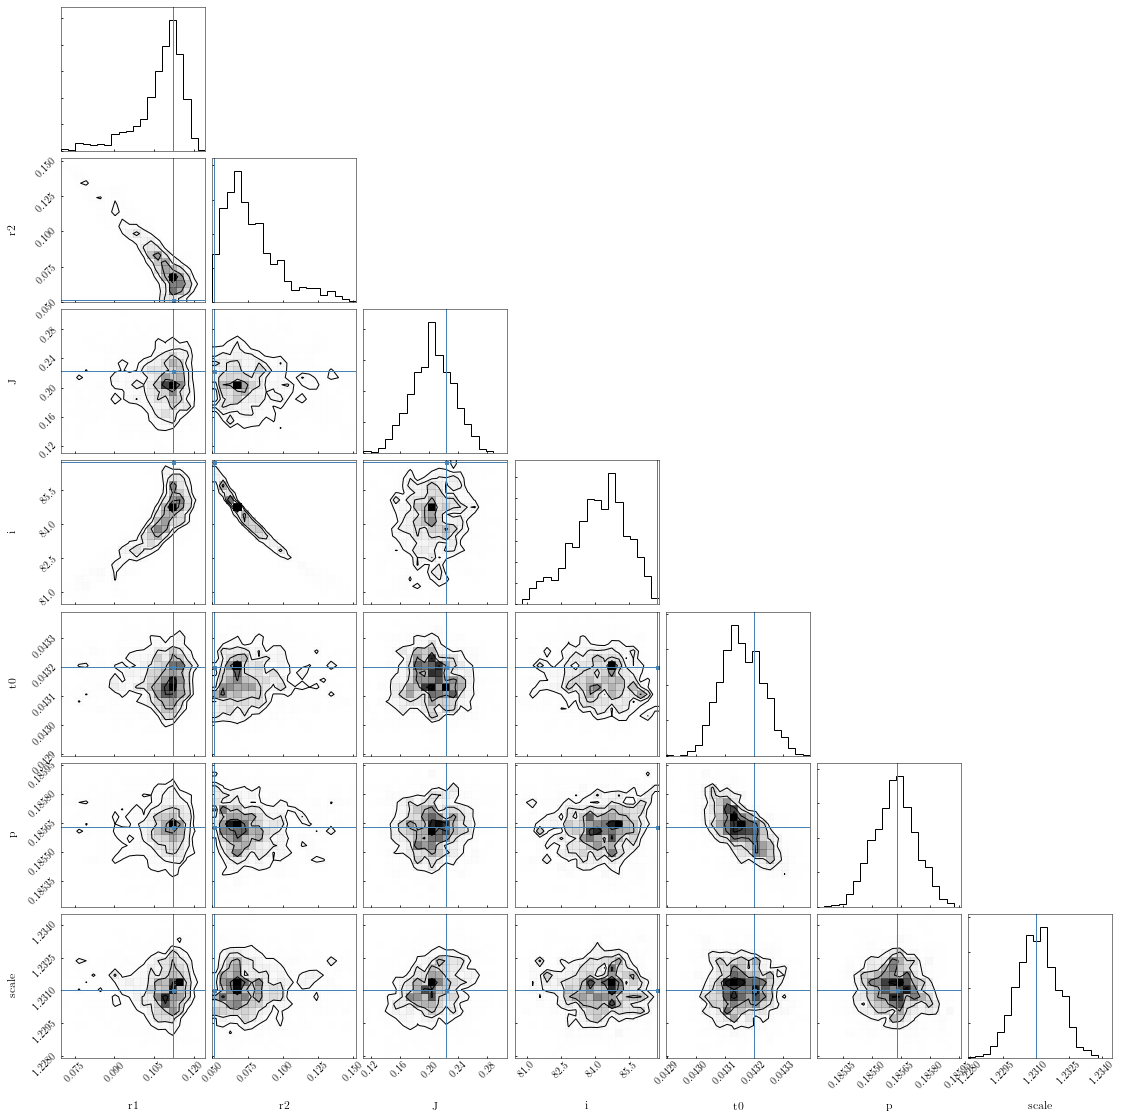

In [158]:
# now lets check the parameter uncertainties and correlations:

import corner
labels = 'r1 r2 J i t0 p scale'.split()
corner.corner(sampler.flatchain[-50*nwalkers:],labels=labels,truths=model_pars,plot_datapoints=False)
plt.show()
